In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from ipywidgets import IntProgress
from keras_tqdm import TQDMNotebookCallback

import keras
import keras.preprocessing.image
from keras.applications.imagenet_utils import get_file

import keras_resnet.models
import keras_retinanet.layers
import keras_retinanet.models

import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
import math

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

Using TensorFlow backend.


In [2]:
def create_model(num_classes=2, *args, **kwargs):
    image = keras.layers.Input((512, 512, 3))
    im_info = keras.layers.Input((3,))
    gt_boxes = keras.layers.Input((None, 5))
    
    return keras_retinanet.models.ResNet50RetinaNet([image, im_info, gt_boxes], num_classes=num_classes)

model = create_model()

# load imagenet weights
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', WEIGHTS_PATH_NO_TOP, cache_subdir='models', md5_hash='a268eb855778b3df3c7506639542a6af')
model.load_weights(weights_path, by_name=True)

# compile model
model.compile(loss=None, optimizer=keras.optimizers.sgd(lr=0.01, momentum=0.9, decay=0.0001))
#print(model.summary())

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Output "classification_softmax" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "classification_softmax" during training.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Output "concatenate_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "concatenate_8" during training.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Output "focal_loss_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "focal_loss_1" during training.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Output "concatenate_7" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "concatenate_7" during tr

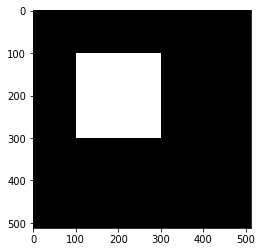

(1, 512, 512, 3) (1, 3) (1, 1, 5)


In [3]:
# generate really simple image with one object
image = np.zeros((512, 512, 3), dtype=keras.backend.floatx())
image[100:300, 100:300, :] = 1.0
plt.imshow(image)
plt.show()

# create input batch blobs
image_batch = np.expand_dims(image, axis=0)
im_info_batch = np.array([[512, 512, 1.0]])
gt_boxes_batch = np.array([[[100, 100, 300, 300, 1]]])

inputs = [image_batch, im_info_batch, gt_boxes_batch]

def simple_data_generator():
    while True:
        yield inputs, None

print(image_batch.shape, im_info_batch.shape, gt_boxes_batch.shape)

In [4]:
# train for some iterations
model.fit_generator(
    generator=simple_data_generator(),
    steps_per_epoch=100,
    epochs=15,
    verbose=1
)

Epoch 1/15
100/100 [==============================] - 16s - loss: 0.4958    
Epoch 2/15
100/100 [==============================] - 10s - loss: 6.1573e-05    
Epoch 3/15
100/100 [==============================] - 10s - loss: 3.1098e-05    
Epoch 4/15
100/100 [==============================] - 10s - loss: 2.0863e-05    
Epoch 5/15
100/100 [==============================] - 10s - loss: 1.5440e-05    
Epoch 6/15
100/100 [==============================] - 10s - loss: 1.2124e-05    
Epoch 7/15
100/100 [==============================] - 10s - loss: 9.8986e-06    
Epoch 8/15
100/100 [==============================] - 10s - loss: 8.3127e-06    
Epoch 9/15
100/100 [==============================] - 10s - loss: 7.1460e-06    
Epoch 10/15
100/100 [==============================] - 10s - loss: 6.2527e-06    
Epoch 11/15
100/100 [==============================] - 10s - loss: 5.5488e-06    
Epoch 12/15
100/100 [==============================] - 10s - loss: 4.9827e-06    
Epoch 13/15
100/100 [========

In [5]:
# predict the same image again
classification, labels, cls_loss, anchors = model.predict_on_batch(inputs)

(1, 12240) (1, 12240, 2) (1, 12240, 4)
1.0 [ 0.00666258  0.99333739]
1.0 [  3.34702025e-04   9.99665260e-01]
1.0 [ 0.0110987   0.98890126]
1.0 [ 0.00323502  0.99676502]
1.0 [  4.17040610e-05   9.99958277e-01]
1.0 [  8.02129125e-06   9.99992013e-01]
1.0 [  3.94867238e-04   9.99605119e-01]
1.0 [  1.02005768e-04   9.99897957e-01]
1.0 [  3.95044044e-04   9.99605000e-01]
1.0 [ 0.01033688  0.98966306]
1.0 [ 0.0094928   0.99050713]
1.0 [  9.11216432e-07   9.99999046e-01]
1.0 [  2.16826210e-11   1.00000000e+00]
1.0 [  7.33204400e-11   1.00000000e+00]
1.0 [  2.50683530e-16   1.00000000e+00]
1.0 [  8.84166695e-08   9.99999881e-01]
1.0 [  1.91244744e-08   1.00000000e+00]
1.0 [  3.98018580e-15   1.00000000e+00]
1.0 [  1.07011005e-13   1.00000000e+00]
1.0 [  4.25768623e-24   1.00000000e+00]
1.0 [  5.34723266e-10   1.00000000e+00]
1.0 [  7.58171720e-11   1.00000000e+00]
1.0 [  1.73536567e-11   1.00000000e+00]
1.0 [  3.06059519e-04   9.99693990e-01]
1.0 [ 0.00720659  0.99279344]
1.0 [  2.09298378e-06

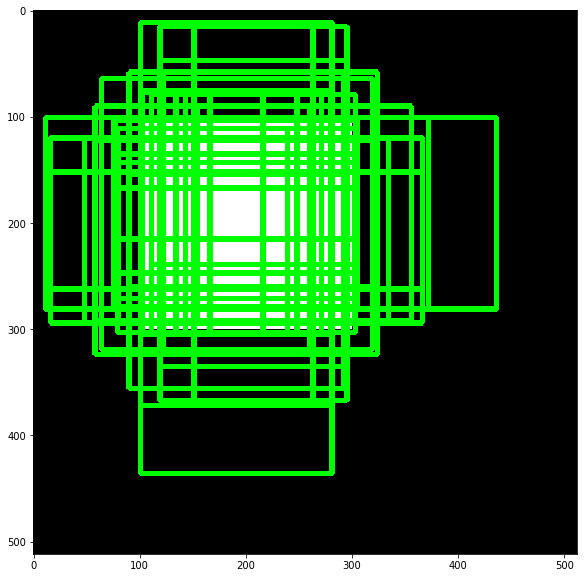

In [7]:
# visualize the positive anchors
indices = np.where(labels[0, :] > 0)[0]
im = image_batch[0, ...].copy()
print(labels.shape, classification.shape, anchors.shape)
for idx in indices:
    # print the label and the classification scores
    print(labels[0, idx], classification[0, idx, :])
    b = anchors[0, idx, :].astype(int)
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), (0, 1, 0), 3)
    
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.show()

### Generate anchors for a certain image size

In [7]:
import keras_retinanet.layers

im_info = keras.layers.Input((3,))
gt_boxes = keras.layers.Input((None, 5))

shapes = [(64, 64), (32, 32), (16, 16), (8, 8), (4, 4)]
strides = [8, 16, 32, 64, 128]
sizes = [32, 64, 128, 256, 512]
idx = 2

labels, bbox_reg_targets, anchors = keras_retinanet.layers.AnchorTarget(shapes[idx], strides[idx], sizes[idx])([im_info, gt_boxes])
anchor_model = keras.models.Model(inputs=[im_info, gt_boxes], outputs=[labels, anchors])

l, a = anchor_model.predict([im_info_batch, gt_boxes_batch])

In [ ]:
# show labeled anchors
indices = np.where(l[0, :] > 0)[0]
im = image_batch[0, ...].copy()
for idx in indices:
    b = a[0, idx, :].astype(int)
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), (0, 1, 0), 3)
    
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.show()